In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController, ControlNoiseInit
from utils import transform_angle_error, transform_02pi_to_negpospi, Simulator, Path, Trajectory
from neural_networks.dynamics_networks import TransferNN

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
import os
from pathlib import Path

plt.style.use(["science", "vibrant"])
ls = {"loose dash": (0, (5, 10)), "dash": (0, (5, 5))}

In [2]:
import tensorflow as tf

# Pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

### Controller Definition

In [3]:
# Get neural network model loaded
pend_model_path = Path(os.getcwd()).parent / "neural_networks" / "pendulum" / "models"
pend_availible_models = [x for x in pend_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(pend_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
pend_nn_model = tf.keras.models.load_model(pend_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__24-04-2023 23:00:02
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_20-04-2023 02:54:16
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__23-04-2023 02:48:16
[4]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:34:02
[5]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_model_16nodes_rollouts
[6]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:29:47
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [4]:
from systems.dynamical_systems import Pendulum

pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

def terminal_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([1000, 1])

    return error.T @ Q @ error


def state_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1

    error = np.array([theta_error])
    Q = np.diag([1000])

    return error.T @ Q @ error

pend_controller = SystemController(
    ds=pend,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([2.0 ** 2]),
    exploration_lambda=2e1,
    alpha_mu=0.5,
    alpha_sigma=0.95,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend.u_lo, "max": pend.u_hi},
    control_noise_initialization=ControlNoiseInit.ZERO,
    nn_model=pend_nn_model
)

## Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [5]:
# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([np.radians(170), 6.28])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 5
n_steps = int((1 / pend.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, pend.nx))
truth_states = np.empty((n_steps, pend.nx))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, pend.null_action)).reshape(1, -1)
    nn_current_state = pend_controller.evolve_state(nn_input)[0]
    nn_current_state = pend.ensure_state(nn_current_state)
    
    truth_current_state = pend.simulator(truth_current_state, pend.null_action)
    truth_current_state = pend.ensure_state(truth_current_state)

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_23557/2247950413.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


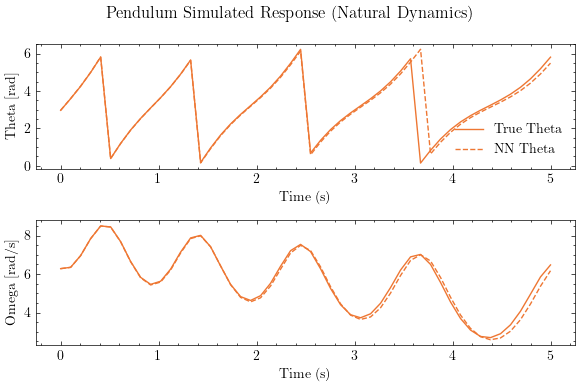

In [6]:
time = np.linspace(0, simulation_length, n_steps)

fig, axd = plt.subplot_mosaic([['t'], ['w']], figsize=(6, 4), layout="constrained")
fig.suptitle("Pendulum Simulated Response (Natural Dynamics)")

p = axd['t'].plot(time, truth_states[:, 0], label="True Theta")
axd['t'].plot(time, nn_states[:, 0], "--", color=p[0].get_color(), label="NN Theta")
axd['t'].set(xlabel="Time (s)", ylabel="Theta [rad]")
axd['t'].legend(loc="lower right")

p = axd['w'].plot(time, truth_states[:, 1], label="True Omega")
axd['w'].plot(time, nn_states[:, 1], "--", color=p[0].get_color(), label="NN Omega")
axd['w'].set(xlabel="Time (s)", ylabel="Omega [rad/s]")
axd['t'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/nn_vs_true_theta_iv.png")

## Pendulum Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [7]:
INITIAL_STATE = np.array([np.radians(0), 0])

pend_env = Simulator(pend, controller=pend_controller)
states, controls, time = pend_env.run(simulation_length=16, initial_state=INITIAL_STATE, controlled=True)

[Simulator] [Info] pendulum simulation elapsed time: 9.10015 s


### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_23557/3963554956.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


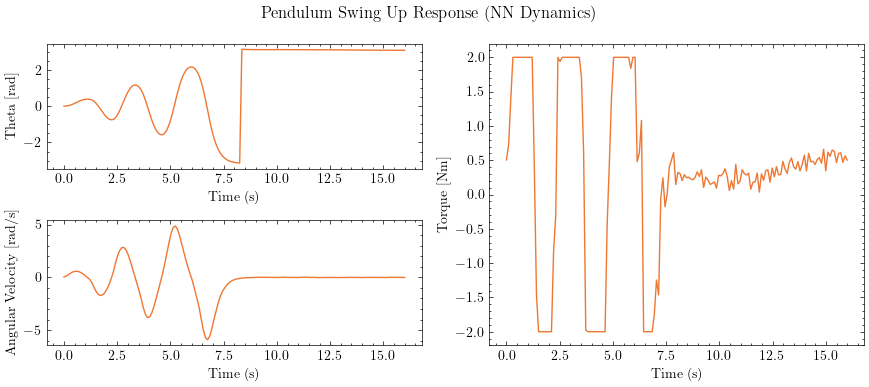

In [8]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response (NN Dynamics)")

axd["ul"].plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/nn_pendulum_swingup.png")

## Online Learning Example
Let's change the inertial properties of the inverted pendulum system and continuously train the dynamics model on newly collected data.

In [9]:
ONLINE_LR = 1e-2

pend_env = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)
pend_base_model = tf.keras.models.load_model(pend_availible_models[idx])
pend_transfer_model = TransferNN(base_model=pend_base_model, lr=ONLINE_LR)

def nn_evolve_state(nn_input):
    states, controls = nn_input[:, :pend_env.nx], nn_input[:, pend_env.nx:]
    x_ddots = pend_transfer_model.transfer_model(nn_input)

    x_dots = states[:, 1::2]

    next_states = states
    next_states[:, ::2] += x_dots * pend_env.dt + 1 / 2 * x_ddots * (pend_env.dt ** 2)
    next_states[:, 1::2] += x_ddots * pend_env.dt

    return next_states

pend_controller = SystemController(
    ds=pend_env,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([0.5 ** 2]),
    exploration_lambda=1e-2,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend_env.u_lo, "max": pend_env.u_hi},
    nn_model=pend_nn_model
)

Model: "transfer_learning_dynamics_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_input (InputL  [(None, None)]           0         
 ayer)                                                           
                                                                 
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 transfer_layer (Dense)      (None, 16)                528       
                                                                 
 out_layer (Dense)           (None, 1

TypeError: __init__() missing 2 required positional arguments: 'alpha_mu' and 'alpha_sigma'

In [ ]:
# Set up online learning parameters
RETRAIN_ITERS = 2

def init_new_data():
    new_examples = np.empty((RETRAIN_ITERS, pend_env.nx + pend_env.nu))
    new_labels = np.empty((RETRAIN_ITERS, pend_env.nx // 2))
    
    return new_examples, new_labels

def label_from_states(initial_state, next_state):
    acceleration = (next_state[1::2] - initial_state[1::2]) / pend_env.dt
    return acceleration

x_data, y_data = init_new_data()

# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([np.radians(45), 0])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 30
n_steps = int((1 / pend_env.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, pend_env.nx))
truth_states = np.empty((n_steps, pend_env.nx))

start_time = perf_counter()

for i in range(n_steps):
    truth_prev_state = pend_env.ensure_state(truth_current_state)
    
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, pend_env.null_action)).reshape(1, -1)
    nn_current_state = nn_evolve_state(nn_input)[0]
    nn_current_state = pend_env.ensure_state(nn_current_state)
    
    truth_current_state = pend_env.simulator(truth_current_state, pend_env.null_action)
    truth_current_state = pend_env.ensure_state(truth_current_state)
    
    x_data[i % RETRAIN_ITERS] = nn_input
    y_data[i % RETRAIN_ITERS] = label_from_states(truth_prev_state, truth_current_state)
    
    # Retrain if current time step is a retrain step
    if i % RETRAIN_ITERS == 0 and i > 0:
        pend_transfer_model.train(x_data, y_data, n_epochs=5)
        x_data, y_data = init_new_data()
        
end_time = perf_counter()
print("time: {:.2f}".format(end_time - start_time))

In [ ]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

fig.suptitle("Pendulum Swing Up Response (NN)")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Theta")
ax1.set(xlabel="Time (s)", ylabel="Theta (rad)")

ax2.plot(time, controls[:, 0], label="Angular Velocity")
ax2.set(xlabel="Time (s)", ylabel="Angular Velocity (rad/s)")

plt.tight_layout()

fig.savefig("figs/pendulum_swingup_online.png")

# Cart-Pole
Try MPPI controller with a cart-pole system

### Controller Definition

In [10]:
# Get neural network model loaded
cartpole_model_path = Path(os.getcwd()).parent / "neural_networks" / "cartpole" / "models"
cartpole_availible_models = [x for x in cartpole_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(cartpole_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
cartpole_nn_model = tf.keras.models.load_model(cartpole_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_rollouts_64__26-04-2023 01:00:47
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_tanh_rollouts_64__26-04-2023 02:01:22


In [11]:
from systems.dynamical_systems import CartPole

# Define the cartpole system parameters
cartpole = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

# Define the controller cost functions
DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([5e4, 1e2, 5e3])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

# Define the neural network and ground truth controllers
DS=cartpole
N_ROLLOUTS=200
HORIZON_LENGTH=10
EXPLORATION_COV=np.diag([10.0 ** 2])
EXPLORATION_LAMBDA=2e3
ALPHA_MU=0.1
ALPHA_SIGMA=0.95
TERMINAL_COST=terminal_cost
STATE_COST=state_cost
CONTROL_RANGE={"min": cartpole.u_lo, "max": cartpole.u_hi}
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=cartpole_nn_model
)

gt_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION
)

## Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [13]:
# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([0.0, 0.0, np.radians(170), 0.0])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 5
n_steps = int((1 / cartpole.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, cartpole.nx))
truth_states = np.empty((n_steps, cartpole.nx))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, cartpole.null_action)).reshape(1, -1)
    nn_current_state = nn_cartpole_controller.evolve_state(nn_input)[0]
    nn_current_state = cartpole.ensure_state(nn_current_state)
    
    truth_current_state = cartpole.simulator(truth_current_state, cartpole.null_action)
    truth_current_state = cartpole.ensure_state(truth_current_state)

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_23557/193014317.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


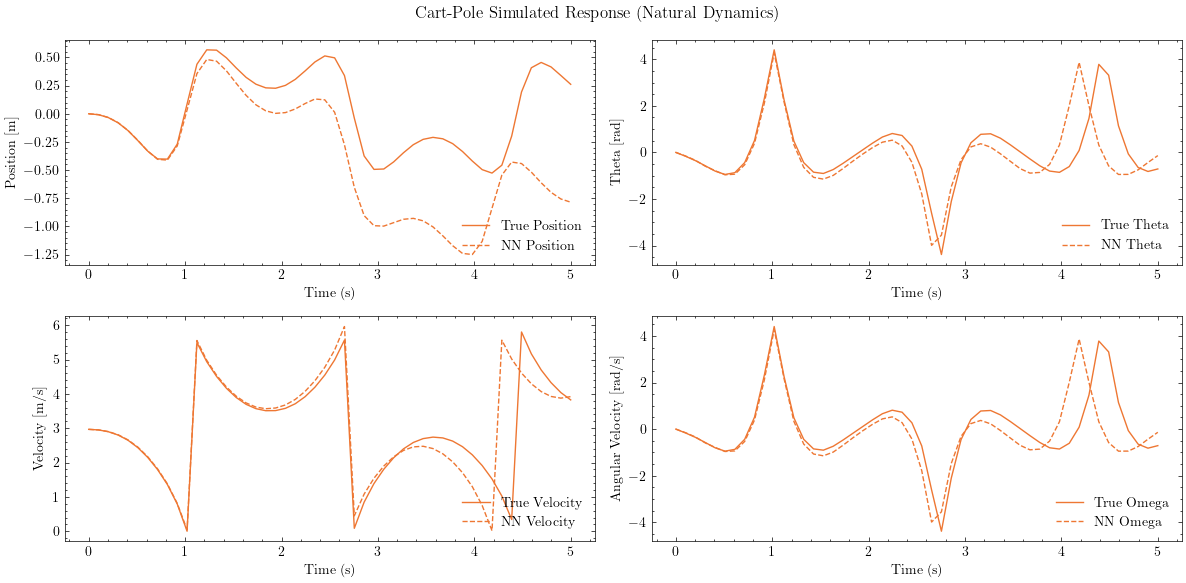

In [14]:
# Plot the simulated response
time = np.linspace(0, simulation_length, n_steps)

fig, axd = plt.subplot_mosaic([['pos', 'theta'],
                               ['vel', 'omega']], figsize=(12, 6), layout="constrained")

fig.suptitle("Cart-Pole Simulated Response (Natural Dynamics)")

p = axd['pos'].plot(time, truth_states[:, 0], label="True Position")
axd['pos'].plot(time, nn_states[:, 0], "--", color=p[0].get_color(), label="NN Position")
axd['pos'].set(xlabel="Time (s)", ylabel="Position [m]")
axd['pos'].legend(loc="lower right")

p = axd['vel'].plot(time, truth_states[:, 2], label="True Velocity")
axd['vel'].plot(time, nn_states[:, 2], "--", color=p[0].get_color(), label="NN Velocity")
axd['vel'].set(xlabel="Time (s)", ylabel="Velocity [m/s]")
axd['vel'].legend(loc="lower right")

p = axd['theta'].plot(time, truth_states[:, 1], label="True Theta")
axd['theta'].plot(time, nn_states[:, 1], "--", color=p[0].get_color(), label="NN Theta")
axd['theta'].set(xlabel="Time (s)", ylabel="Theta [rad]")
axd['theta'].legend(loc="lower right")

p = axd['omega'].plot(time, truth_states[:, 1], label="True Omega")
axd['omega'].plot(time, nn_states[:, 1], "--", color=p[0].get_color(), label="NN Omega")
axd['omega'].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")
axd['omega'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/nn_vs_gt_cartpole.png")

## Cart Pole Swing Up Task
Test the MPPI controller on a cartpole swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [27]:
INITIAL_STATE = np.array([0.0, 0.0, np.radians(0.0), 0.0])
SIMULATION_LENGTH = 8

nn_cartpole_env = Simulator(cartpole, controller=nn_cartpole_controller)
nn_states, nn_controls, time = nn_cartpole_env.run(simulation_length=SIMULATION_LENGTH, initial_state=INITIAL_STATE,
                                                   controlled=True)

gt_cartpole_env = Simulator(cartpole, controller=gt_cartpole_controller)
gt_states, gt_controls, time = gt_cartpole_env.run(simulation_length=SIMULATION_LENGTH, initial_state=INITIAL_STATE,
                                                   controlled=True)

[Simulator] [Info] cart_pole simulation elapsed time: 6.79588 s
[Simulator] [Info] cart_pole simulation elapsed time: 7.26260 s


### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_23557/3535918855.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


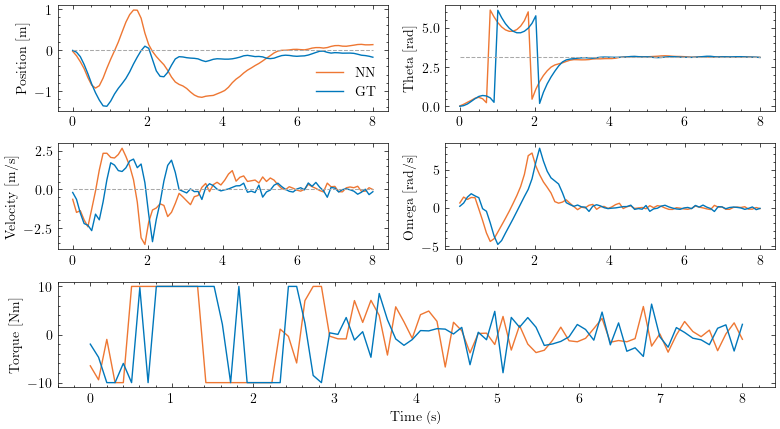

In [36]:
# Plot the results
fig, axd = plt.subplot_mosaic([['pos', 'theta'],
                               ['vel', 'omega'],
                               ['tau', 'tau']], figsize=(8, 4.5), layout="constrained")

axd['pos'].plot(time, nn_states[:, 0], linewidth=1, label="NN")
axd['pos'].plot(time, gt_states[:, 0], linewidth=1, label="GT")
axd['pos'].plot(time, [DESIRED_CARTPOS]*len(time),
                ls="--", linewidth=0.75, color="darkgrey")
axd['pos'].set(ylabel="Position [m]")
axd['pos'].legend(loc="lower right")

axd['vel'].plot(time, nn_states[:, 1], linewidth=1, label="NN")
axd['vel'].plot(time, gt_states[:, 1], linewidth=1, label="GT")
axd['vel'].plot(time, [DESIRED_CARTVEL]*len(time),
                ls="--", linewidth=0.75, color="darkgrey")
axd['vel'].set(ylabel="Velocity [m/s]")

axd['theta'].plot(time, nn_states[:, 2], linewidth=1, label="NN")
axd['theta'].plot(time, gt_states[:, 2], linewidth=1)
axd['theta'].plot(time, [DESIRED_THETA]*len(time),
                  ls="--", linewidth=0.75, color="darkgrey")
axd['theta'].set(ylabel="Theta [rad]")

axd['omega'].plot(time, nn_states[:, 3], linewidth=1, label="NN")
axd['omega'].plot(time, gt_states[:, 3], linewidth=1)
axd['omega'].set(ylabel="Omega [rad/s]")


axd['tau'].plot(time, nn_controls[:, 0], linewidth=1, label="NN")
axd['tau'].plot(time, gt_controls[:, 0], linewidth=1)
axd['tau'].set(ylabel="Torque [Nm]")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("figs/gt_vs_nn_cartpole_swingup.png")

## Cart Pole Swing Up Task with Obstacles
Test the MPPI controller on a cartpole swing-up task with an obstacle that ranges from [-2, 2] on the x-axis

In [ ]:
DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 2.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = transform_angle_error(DESIRED_THETA - theta)
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([40, 1, 4])
    cost = error.T @ Q @ error
    
    if -2 <= pos <= 2:
        cost += 1e3

    return cost

def state_cost(x):
    return terminal_cost(x)

cartpole_obstacle_controller = SystemController(
    ds=cartpole_env,
    n_rollouts=150,
    horizon_length=10,
    exploration_cov=np.diag([2 ** 2]),
    exploration_lambda=1e-7,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": cartpole_env.u_lo, "max": cartpole_env.u_hi},
    nn_model=cartpole_nn_model
).build()

In [ ]:
states, controls, time = run_simulation(ds=cartpole_env, controller=cartpole_obstacle_controller,
                                        simulation_length=6, initial_state=np.array([0, 0, 0, 0]))

In [ ]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'ur'],
                               ['ll', 'lr']], figsize=(9, 4), layout="constrained")

fig.suptitle("Cart-Pole Swing Up Response (NN)")

axd["ul"].plot(time, states[:, 0])
axd["ul"].set(xlabel="Time (s)", ylabel="Position [m]")

axd["ll"].plot(time, states[:, 1])
axd["ll"].set(xlabel="Time (s)", ylabel="Velocity [m/s]")

axd["ur"].plot(time, states[:, 2])
axd["ur"].set(xlabel="Time (s)", ylabel="Angle [m]")

axd["lr"].plot(time, states[:, 3])
axd["lr"].set(xlabel="Time (s)", ylabel="Angular Velocity [m/s]")

plt.tight_layout()
fig.savefig("figs/cartpole_swingup_nn.png")